In [39]:
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam, rmsprop
from keras import backend as K
from keras.callbacks import ModelCheckpoint

### An Unsupervised Approach for Segmentation and Clustering of Soccer Players 

The idea is to assign every newly presented vector  to an existing cluster or create a new cluster for this  sample,  depending  on  the  distance  to  the  already defined clusters. As pseudo the algorithm works like the following:
1. m = 1; Cm = {x1}; // Init first cluster = first sample 
2. for every sample x from 2 to N  
    a. find cluster Ck such that min d(x, Ck)  
    b. if d(x, Ck) > th AND (m < q)   
        i.  m  =  m  +  1;  Cm  =  {x}  //  Create  a new cluster 
    c. else   
        i.  Ck = Ck + {x} // Add sample to the nearest cluster   
        ii. Update representative if needed 3. end algorithm    
3. end algorithm

In [23]:
def image2hist(img_path):
        """
         returs: normalized histogram of image
        :param img_path: link to image
        """
        img = cv2.imread(img_path)
        hists = []
        for i in reversed(range(3)): # BGR -> RGB
            curr_hist = cv2.calcHist([img],[i],None,[256],[0,256]).reshape(1,256)
            curr_hist = curr_hist.sum(axis=0)
            hists.append(curr_hist / np.sum(curr_hist))
        
        return np.array(hists)

    
def dist(x, y):
    """
    calculate the distance between two image points
    :param x: first image point
    :param y: second image point
    """
    return np.sum(np.abs(x-y))

In [24]:

class Bsas(object):
    def __init__(self, threshold, img_coding, max_clusters=3, ascent=0.2):
        """
        param: threshold, threshold distance between two classes
        param: img_coding, function to create image point
        param: max_clusters, number of maximum claster we want to get
        param: ascent, ascent value to thereshold
               
        
        """
        self.th = threshold
        self.img_coding = img_coding
        self.means = []
        self.q = max_clusters
        self.size_of_cluster = []
        self.count = 0
        self.iter = 0
        self.ascent = ascent
    
    
    def merge_clusters(self):
        """
        merge clusters if they are less than threshold
        """
        mark = True
        while mark == True:
            mark = False
            d_min = None
            c1 = None
            c2 = None
            for i in range(self.count):
                for j in range(i+1, self.count):
                    curr_d = dist(self.means[i], self.means[j])
                    if (d_min is None) or curr_d < d_min:
                        d_min = curr_d
                        c1 = i
                        c2 = j
            if d_min is not None and d_min < self.th:
                mark = True
                w_1 = self.size_of_cluster[c1]
                w_2 = self.size_of_cluster[c2]
                self.means[c1] = (w_1 * self.means[c1] + w_2 * self.means[c2]) / (w_1 + w_2)
                self.size_of_cluster[c1] = w_1 + w_2
                del self.means[c2]
                del self.size_of_cluster[c2]
                self.count -= 1
    
    
    def update_cluster(self, k, new_img):
        """
        update cluster centre after inserting new image 
        :param k: winner class 
        :param new_img: histogram of a new image 
        
        """
        w_k = self.size_of_cluster[k]
        self.means[k] = (w_k * self.means[k] + new_img) / (w_k + 1)
        self.size_of_cluster[k] += 1
        
    
    def fit(self, data_paths):
        """
        create clusters
        :param data_paths: list of paths
        """
        self.iter += 1
        print(self.th)
        for img_path in data_paths:
            img_point = self.img_coding(img_path)
            if self.count == 0:
                self.count = 1
                self.means.append(img_point)
                self.size_of_cluster.append(1)

            else:
                k = self.predict([img_path])[0]
                d = dist(img_point, self.means[k])

                if d > self.th and self.count < self.q:
                    self.count += 1
                    self.means.append(img_point)
                    self.size_of_cluster.append(1)
                    
                elif d <= self.th:
                    self.update_cluster(k, img_point)
                
                else:
                    #retrain
                    self.th = self.th * (1 + self.ascent / self.iter) 
                    self.means = []
                    self.size_of_cluster = []
                    self.count = 0
                    self.fit(data_paths)
                    break
#case for mer                
#         self.merge_clusters()
#         if self.count > self.q:
#             # retrain
#             self.th = self.th * (1 + self.ascent / self.iter) 
#             self.means = []
#             self.size_of_cluster = []
#             self.count = 0
#             self.fit(data_paths)


    def predict(self, data_paths):
        """
        Returns list of indexes of the clusters each point is most likely to belong.
        :param data_paths: list of paths
        """
        labels = []
        for img_path in data_paths: 
            img_point = self.img_coding(img_path)
            d = []
            for cluster in self.means:
                d.append(dist(img_point, cluster))
            labels.append(np.argmin(d))
        return labels
    
    
    def num_of_clusters(self):
        
        return self.count

In [25]:
import os
imgs = []
for root, directories, filenames in os.walk('./Data/'):
    for filename in filenames: 
        if (filename.endswith(".jpg") or filename.endswith(".png")):
            if ('green' not in os.path.join(root,filename)) and ('yellow' not in os.path.join(root,filename)): 
                imgs.append(os.path.join(root,filename))

In [29]:
perm = np.random.permutation(len(imgs))
imgs = np.array(imgs)
imgs = imgs[perm]

In [27]:
model = Bsas(threshold=3, 
             img_coding=image2hist, 
             max_clusters=3, 
             ascent=0.05)

model.fit(imgs.tolist())

3
3.1500000000000004
3.2287500000000002
3.2825625
3.32359453125
3.3568304765625
3.3848040638671875
3.408981235751953


In [28]:
model.num_of_clusters()

3

In [30]:
# for each lable create vector of clusters 
green =[]
red_blue=[]
black=[]
orange=[]
yellow=[]

for i in range(len(imgs)):
    if "green" in imgs[i]:
        green.append(model.predict([imgs[i]])[0])
    if "black" in imgs[i]:
        black.append(model.predict([imgs[i]])[0])
    if "red-blue" in imgs[i]:
        red_blue.append(model.predict([imgs[i]])[0])
    if "orange" in imgs[i]:
        orange.append(model.predict([imgs[i]])[0])
    if "yellow" in imgs[i]:
        yellow.append(model.predict([imgs[i]])[0])

In [31]:
for i in range(model.count):
    print("cluster {}: ".format(i), model.size_of_cluster[i])

cluster 0:  7939
cluster 1:  6652
cluster 2:  1678


In [19]:
len(black) + len(red_blue) + len(yellow)

14831

In [20]:
#count most common elements in lables
from collections import Counter

#green_cl = Counter(green).most_common()[0][0]
black_cl = Counter(black).most_common()[0][0]
red_blue_cl = Counter(red_blue).most_common()[0][0]
orange_cl = Counter(orange).most_common()[0][0]
#yellow_cl = Counter(yellow).most_common()[0][0]

In [21]:
black_cl, red_blue_cl, orange_cl

(1, 0, 2)

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


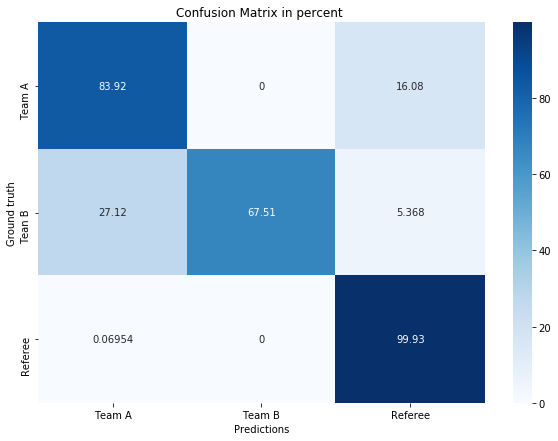

In [158]:
#dysplay confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=False, precision=4)

y_true = len(red_blue) * [red_blue_cl] + len(orange) * [orange_cl] + len(black) * [black_cl]
y_pred = red_blue + orange + black
C = confusion_matrix(y_true, y_pred)
C = C * 100 / C.astype(np.float32).sum(axis=1)[:, None]


df = pd.DataFrame(C, index = ['Team A', 'Tean B', 'Referee'],
                  columns = ['Team A', 'Team B', 'Referee'])
df.index.name = 'Ground truth'
df.columns.name = 'Predictions'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix in percent ')
sns.heatmap(df, annot=True, cmap=plt.cm.Blues,  fmt='.4g')

### Using Convolutional Autoencoders we will try to use feature extraction for image clustering

In [64]:
input_img = Input(shape=(40, 24, 3))  

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
maxpool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D((2, 2), padding='same')(conv2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool2)
encoder = MaxPooling2D((2, 2), padding='same')(conv3)

print("shape of encoded", encoder._keras_shape)

conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
upsample1 = UpSampling2D((2, 2))(conv4)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(upsample1)
upsample2 = UpSampling2D((2, 2))(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(upsample2)
upsample3 = UpSampling2D((2, 2))(conv6)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(upsample3)

#print("shape of decoder", decoder._keras_shape)
model_encoding = Model(input_img, encoder)
autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer="adadelta", loss='binary_crossentropy')

shape of encoded (None, 5, 3, 32)


In [65]:
X = []
for img_path in imgs:
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (24, 40)) 
    X.append(resized_img)

X = np.array(X).astype('float32') / 255.
train_size = int(len(X) * 0.9)
X_train, X_val = X[:train_size], X[train_size:]

In [66]:
checkpoint = ModelCheckpoint(filepath="model_weights/autoencoder_weigths.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
autoencoder.fit(X_train, X_train,
                epochs=100, batch_size=128, shuffle=True, 
                validation_data=(X_val, X_val),
                callbacks=[checkpoint])

Train on 14642 samples, validate on 1627 samples
Epoch 1/100
14642/14642 [==============================] - 118s 8ms/step - loss: 0.6519 - val_loss: 0.6598
Epoch 2/100
14642/14642 [==============================] - 116s 8ms/step - loss: 0.6305 - val_loss: 0.6269
Epoch 3/100
14642/14642 [==============================] - 116s 8ms/step - loss: 0.6244 - val_loss: 0.6222
Epoch 4/100
14642/14642 [==============================] - 113s 8ms/step - loss: 0.6208 - val_loss: 0.6206
Epoch 5/100
14642/14642 [==============================] - 110s 8ms/step - loss: 0.6185 - val_loss: 0.6189
Epoch 6/100
14642/14642 [==============================] - 110s 8ms/step - loss: 0.6165 - val_loss: 0.6179
Epoch 7/100
14642/14642 [==============================] - 111s 8ms/step - loss: 0.6151 - val_loss: 0.6180
Epoch 8/100
14642/14642 [==============================] - 111s 8ms/step - loss: 0.6144 - val_loss: 0.6150
Epoch 9/100
14642/14642 [==============================] - 110s 8ms/step - loss: 0.6134 - val_l

Epoch 33/100
14642/14642 [==============================] - 117s 8ms/step - loss: 0.6056 - val_loss: 0.6079
Epoch 34/100
14642/14642 [==============================] - 123s 8ms/step - loss: 0.6055 - val_loss: 0.6072
Epoch 35/100
14642/14642 [==============================] - 123s 8ms/step - loss: 0.6053 - val_loss: 0.6070
Epoch 36/100
14642/14642 [==============================] - 121s 8ms/step - loss: 0.6051 - val_loss: 0.6070
Epoch 37/100
14642/14642 [==============================] - 117s 8ms/step - loss: 0.6049 - val_loss: 0.6068
Epoch 38/100
14642/14642 [==============================] - 118s 8ms/step - loss: 0.6048 - val_loss: 0.6065
Epoch 39/100
14642/14642 [==============================] - 117s 8ms/step - loss: 0.6046 - val_loss: 0.6073
Epoch 40/100
14642/14642 [==============================] - 116s 8ms/step - loss: 0.6045 - val_loss: 0.6064
Epoch 41/100
14642/14642 [==============================] - 116s 8ms/step - loss: 0.6044 - val_loss: 0.6064
Epoch 42/100
14642/14642 [==

KeyboardInterrupt: 

In [67]:
autoencoder.load_weights("model_weights/autoencoder_weigths.hdf5")

In [144]:
def image_encoder(img_path):
        """
         returs: encoded image
        :param img_path: link to image
        """
        img = cv2.imread(img_path)
        resized_img = cv2.resize(img, (24, 40)) 
        vec = model_encoding.predict(resized_img[None, :]).flatten()
        return (vec / 1000) ** 2

In [146]:
model_encoder = Bsas(threshold=12, 
             img_coding=image_encoder, 
             max_clusters=3, 
             ascent=0.1)

model_encoder.fit(imgs.tolist())

12
13.200000000000001
13.860000000000001
14.322000000000003


In [147]:
model_encoder.num_of_clusters()

3

In [148]:
# for each lable create vector of clusters 
green =[]
red_blue=[]
black=[]
orange=[]
yellow=[]

for i in range(len(imgs)):
    if "green" in imgs[i]:
        green.append(model_encoder.predict([imgs[i]])[0])
    if "black" in imgs[i]:
        black.append(model_encoder.predict([imgs[i]])[0])
    if "red-blue" in imgs[i]:
        red_blue.append(model_encoder.predict([imgs[i]])[0])
    if "orange" in imgs[i]:
        orange.append(model_encoder.predict([imgs[i]])[0])
    if "yellow" in imgs[i]:
        yellow.append(model_encoder.predict([imgs[i]])[0])

In [149]:
for i in range(model_encoder.count):
    print("cluster {}: ".format(i), model_encoder.size_of_cluster[i])

cluster 0:  6373
cluster 1:  8381
cluster 2:  1515


In [150]:
len(black) + len(red_blue) + len(yellow)

14831

In [151]:
#count most common elements in lables
from collections import Counter

#green_cl = Counter(green).most_common()[0][0]
black_cl = Counter(black).most_common()[0][0]
red_blue_cl = Counter(red_blue).most_common()[0][0]
orange_cl = Counter(orange).most_common()[0][0]
#yellow_cl = Counter(yellow).most_common()[0][0]

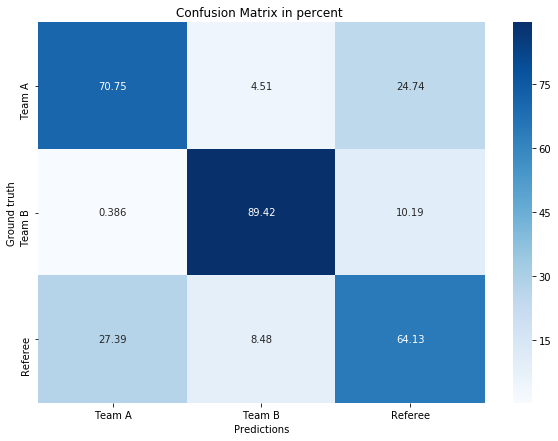

In [163]:
#dysplay confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=False, precision=4)

y_true = len(red_blue) * [red_blue_cl] + len(orange) * [orange_cl] + len(black) * [black_cl]
y_pred = red_blue + orange + black
C = confusion_matrix(y_true, y_pred)
C = C * 100 / C.astype(np.float32).sum(axis=1)[:, None]

df = pd.DataFrame(C, index = ['Team A', 'Team B', 'Referee'],
                  columns = ['Team A', 'Team B', 'Referee'])
df.index.name = 'Ground truth'
df.columns.name = 'Predictions'
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix in percent ')
sns.heatmap(df, annot=True, cmap=plt.cm.Blues,  fmt='.4g')